In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummaryX import summary
import matplotlib.pyplot as plt
import time
import os

from UnarySim.sw.kernel.nn_utils import *
from UnarySim.sw.kernel.linear import *
from UnarySim.sw.kernel.relu import UnaryReLU
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError

In [3]:
cwd = os.getcwd()
print(cwd)

D:\project\Anaconda3\Lib\site-packages\UnarySim\sw\test


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
# MNIST data loader
transform=transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root=cwd+'/data/mnist', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)

testset = torchvision.datasets.MNIST(root=cwd+'/data/mnist', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, num_workers=4)

# test binary model clamp

In [6]:
model_path = cwd+"\saved_model_state_dict_8_clamp"
model_clamp = MLP3_clamp_eval()
model_clamp.to(device)
model_clamp.load_state_dict(torch.load(model_path))
model_clamp.eval()
model_clamp.to(device)
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model_clamp(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 96.080000 %


# test unary model nonscaled addition - clamp binary

--- 117.79590392112732 seconds ---
100 images are done!!!
--- 233.86700177192688 seconds ---
200 images are done!!!
--- 349.72913002967834 seconds ---
300 images are done!!!
--- 467.6069815158844 seconds ---
400 images are done!!!
--- 584.670756816864 seconds ---
500 images are done!!!
--- 700.9458310604095 seconds ---
600 images are done!!!
--- 817.465390920639 seconds ---
700 images are done!!!
--- 933.5371603965759 seconds ---
800 images are done!!!
--- 1050.2224917411804 seconds ---
900 images are done!!!
--- 1169.4167454242706 seconds ---
1000 images are done!!!
--- 1285.9719319343567 seconds ---
1100 images are done!!!
--- 1402.059403181076 seconds ---
1200 images are done!!!
--- 1522.833696603775 seconds ---
1300 images are done!!!
--- 1639.7439551353455 seconds ---
1400 images are done!!!
--- 1758.0403072834015 seconds ---
1500 images are done!!!
--- 1875.058111667633 seconds ---
1600 images are done!!!
--- 1994.41672539711 seconds ---
1700 images are done!!!
--- 2114.304099559

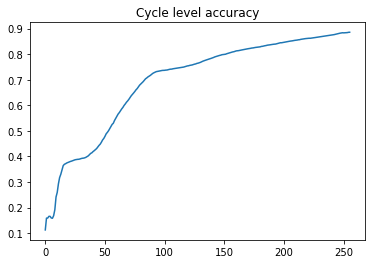

In [7]:
correct_binary = 0
correct_unary = 0

bitwidth = 8
total = 0

# binary MLP3_clamp weight init
rng = "Sobol"
encode = "RC"
rng_dim = 1
relu_buf_dep = 4
mode = "bipolar"
scaled = False
bias = True
sample_cnt = 20000

start_cnt = 0
current_index = 0

cycle_correct = torch.zeros(2**(bitwidth)).to(device)

start_time = time.time()

with torch.no_grad():
    for data in testloader:
        if current_index < start_cnt:
            current_index = current_index + 1
            continue
        current_index = current_index + 1

        total += labels.size(0)

        images, labels = data[0].to(device), data[1].to(device)
        
        # reference binary mlp
        outputs_binary = model_clamp(images)
        _, predicted_binary = torch.max(outputs_binary.data, 1)
        correct_binary += (predicted_binary == labels).sum().item()
        
#         print(model_clamp.fc1_out.min().item(), model_clamp.fc1_out.max().item())
#         print(model_clamp.fc2_out.min().item(), model_clamp.fc2_out.max().item())
#         print(model_clamp.fc3_out.min().item(), model_clamp.fc3_out.max().item())


        # unary part
        # input image check
        image = images.view(-1, 32*32)
        image_SRC = SourceGen(image, bitwidth=bitwidth, mode=mode)().to(device)
        image_RNG = RNG(bitwidth, rng_dim, rng)().to(device)
        image_BSG = BSGen(image_SRC, image_RNG).to(device)
        image_ERR = ProgressiveError(image, mode=mode).to(device)
        
        # unary mlp is decomposed into separate layers
        fc1_unary = GainesLinear1(32*32, 512, model_clamp.fc1.weight.data, model_clamp.fc1.bias.data, 
                                 bitwidth=bitwidth, mode=mode, scaled=scaled, bias=bias, depth=bitwidth, rng_idx=2).to(device)
        fc1_ERR = ProgressiveError(model_clamp.fc1_out, mode=mode).to(device)
        
        fc2_unary = GainesLinear1(512, 512, model_clamp.fc2.weight.data, model_clamp.fc2.bias.data, 
                                 bitwidth=bitwidth, mode=mode, scaled=scaled, bias=bias, depth=bitwidth, rng_idx=3).to(device)
        fc2_ERR = ProgressiveError(model_clamp.fc2_out, mode=mode).to(device)

        fc3_unary = GainesLinear1(512, 10, model_clamp.fc3.weight.data, model_clamp.fc3.bias.data, 
                                 bitwidth=bitwidth, mode=mode, scaled=scaled, bias=bias, depth=bitwidth, rng_idx=4).to(device)
        fc3_ERR = ProgressiveError(model_clamp.fc3_out, mode=mode).to(device)
        
        relu1_unary = UnaryReLU(depth=relu_buf_dep, bitwidth=bitwidth, encode=encode).to(device)
        relu1_ERR = ProgressiveError(model_clamp.relu1_out, mode=mode).to(device)
        
        relu2_unary = UnaryReLU(depth=relu_buf_dep, bitwidth=bitwidth, encode=encode).to(device)
        relu2_ERR = ProgressiveError(model_clamp.relu2_out, mode=mode).to(device)
        
        if total%100 == 0:
            print("--- %s seconds ---" % (time.time() - start_time))
            print(total, "images are done!!!")

#         print(current_index, "-th image with label", labels.item(), ", total image count", total)
        for i in range(2**(bitwidth)):
            idx = torch.zeros(image_SRC.size()).type(torch.long).to(device)
            image_bs = image_BSG(idx + i)
            image_ERR.Monitor(image_bs)
            # print(image_bs.shape)
            # fc1
            fc1_unary_out   = fc1_unary(image_bs)
#             fc1_ERR.Monitor(fc1_unary_out)
            # print(fc1_unary_out.shape)
            # relu1
            relu1_unary_out = relu1_unary(fc1_unary_out)
#             relu1_ERR.Monitor(relu1_unary_out)
            # print(relu1_unary_out.shape)
            # fc2
            fc2_unary_out   = fc2_unary(relu1_unary_out)
#             fc2_ERR.Monitor(fc2_unary_out)
            # print(fc2_unary_out.shape)
            # relu2
            relu2_unary_out = relu2_unary(fc2_unary_out)
#             relu2_ERR.Monitor(relu2_unary_out)
            # print(relu2_unary_out.shape)
            # fc3
            fc3_unary_out   = fc3_unary(relu2_unary_out)
            fc3_ERR.Monitor(fc3_unary_out)
            # print(fc3_unary_out.shape)
            
            _, predicted_unary = torch.max(fc3_ERR()[0], 1)
            if predicted_unary == labels:
#                 print(current_index, "-th image succeeds.")
#                 print(current_index, "-th image with label", labels.item(), ", total image count", total)
#                 print("before", predicted_unary.item(), cycle_correct[predicted_unary.item()].item())
                cycle_correct[i].add_(1)
#                 print("after", predicted_unary.item(), cycle_correct[predicted_unary.item()].item())

#         to_print = 1
#         print("image: ", 
#               image_ERR()[to_print].min().item(), 
#               image_ERR()[to_print].max().item(),
#               image_ERR()[to_print].mul(image_ERR()[to_print]).mean().sqrt().item())
#         print("fc1:   ", 
#               fc1_ERR()[to_print].min().item(), 
#               fc1_ERR()[to_print].max().item(), 
#               fc1_ERR()[to_print].mul(fc1_ERR()[to_print]).mean().sqrt().item())
#         print("relu1: ", 
#               relu1_ERR()[to_print].min().item(), 
#               relu1_ERR()[to_print].max().item(), 
#               relu1_ERR()[to_print].mul(relu1_ERR()[to_print]).mean().sqrt().item())
#         print("fc2:   ", 
#               fc2_ERR()[to_print].min().item(), 
#               fc2_ERR()[to_print].max().item(), 
#               fc2_ERR()[to_print].mul(fc2_ERR()[to_print]).mean().sqrt().item())
#         print("relu1: ", 
#               relu2_ERR()[to_print].min().item(), 
#               relu2_ERR()[to_print].max().item(), 
#               relu1_ERR()[to_print].mul(relu1_ERR()[to_print]).mean().sqrt().item())
#         print("fc3:   ", 
#               fc3_ERR()[to_print].min().item(), 
#               fc3_ERR()[to_print].max().item(), 
#               fc3_ERR()[to_print].mul(fc3_ERR()[to_print]).mean().sqrt().item())
        
        _, predicted_unary = torch.max(fc3_ERR()[0], 1)
        correct_unary += (predicted_unary == labels).sum().item()
        if total == sample_cnt:
            break

print('Accuracy of the network on %d test images: %f %%' % (total,
    100 * correct_binary / total))
print('Accuracy of the network on %d test images: %f %%' % (total,
    100 * correct_unary / total))

result = cycle_correct.cpu().numpy()/total
fig = plt.plot([i for i in range(2**bitwidth)], result)  # arguments are passed to np.histogram
plt.title("Cycle level accuracy")
plt.show()

with open("cycle_accuracy_mlp_nonscaled_clamp_gaines.csv", "w+") as f:
    for i in result:
        f.write(str(i)+", \n")